# Function Definition

In [1]:
from scipy import optimize
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sympy import symbols, diff
import sympy as sp
from scipy.odr import ODR, Model, Data, RealData
import matplotlib.pyplot as plt

In [2]:
def F(m, phi_i, d = 1*10**(-3), lam = 650*10**(-9)):
    """"
    This function takes as inputs the parameters from our experiment and returns another function, only in terms
    of n, such that it can later be optimized while taking our parameteres as fixed.
    
    Parameters
    -------
    m : the number of fringes counter
    d : thickness of the material plate
    lam : wavelength of the light source
    phi_i : angle through which we rotate the plate, to the normal angle of mirror
    
    Returns
    -------
    funk_to_optimize : a function containing the parameters as fixed, in terms of refractive index 'n'
    
    Notes
    -------
    
    """
    
    def funk_to_optimize(n):
        
        phi_r = math.asin(math.sin(phi_i)/n)
        
        return m - (2*d)/lam * (n*(1/math.cos(phi_r) - 1)
                                + 1 - (math.cos(phi_i - phi_r)/math.cos(phi_r)))
    
    return funk_to_optimize

In [3]:
def refrakt(input_data, x0 = 1.4, x1 = 1.5):
    """
    This one takes a list of data and returns the refractive index
    
    Params
    -------
    input_data : experimental data that contains number of fringes 
                 and angle of rotation
    x0 = initial guess for optimization algorithm
    x1 = second guess for optimization algorithm
    
    Returns
    -------
    output_data : list of refractive indices
    
    Example
    -------
    >>>refrakt([[20, 10.4], [40, 14.7]])
    [4.79289677e+34, 4.28057195e+31]
    
    Notes
    -------
    We know that we are measuring glass-like material, so we expect 
    the refractive index to be somewhere between 1.4 and 1.5, hence 
    the default values for the initial two guesses
    
    """
    output_data = []
    
    for arr in input_data:
        
        m = arr[0]
        phi_i = arr[1]
    
        func = F(m, phi_i)
        n = optimize.root_scalar(func, x0 = x0, x1 = x1)
    
        output_data.append(n.root)
        
    return output_data

# Data Import and Analysis

In [4]:
def load(url):
    run = pd.read_csv(url, dtype = "float").to_numpy()
    
    run[:,1] = np.radians(run[:,1])
    
    
    return run

In [95]:
runB1 = load("https://raw.githubusercontent.com/diodeamy/Waves-And-Optics/main/data/data_BR1.csv")
runB2 = load("https://raw.githubusercontent.com/diodeamy/Waves-And-Optics/main/data/data_BR2.csv")
runB3 = load("https://raw.githubusercontent.com/diodeamy/Waves-And-Optics/main/data/data_BR3.csv")
runW1 = load("https://raw.githubusercontent.com/diodeamy/Waves-And-Optics/main/data/data_WR1.csv")
runW2 = load("https://raw.githubusercontent.com/diodeamy/Waves-And-Optics/main/data/data_WR2.csv")

In [89]:
def del_points(run):
    run_del = np.delete(run, [0, 1, 2, 3, 4], 0)
    
    return run_del

In [96]:
runB1 = del_points(runB1)
runB2 = del_points(runB2)
runB3 = del_points(runB3)
runW1 = del_points(runW1)
runW2 = del_points(runW2)

In [97]:
runB1

array([[8.00000000e+00, 1.04719755e-01],
       [1.00000000e+01, 1.22173048e-01],
       [1.20000000e+01, 1.39626340e-01],
       [1.40000000e+01, 1.57079633e-01],
       [1.70000000e+01, 1.74532925e-01],
       [2.00000000e+01, 1.91986218e-01],
       [2.30000000e+01, 2.09439510e-01],
       [2.60000000e+01, 2.26892803e-01],
       [3.10000000e+01, 2.44346095e-01],
       [3.60000000e+01, 2.61799388e-01],
       [4.10000000e+01, 2.79252680e-01],
       [4.50000000e+01, 2.96705973e-01],
       [5.00000000e+01, 3.14159265e-01],
       [5.50000000e+01, 3.31612558e-01],
       [6.20000000e+01, 3.49065850e-01],
       [6.90000000e+01, 3.66519143e-01],
       [7.50000000e+01, 3.83972435e-01],
       [8.30000000e+01, 4.01425728e-01],
       [9.30000000e+01, 4.18879020e-01],
       [1.03000000e+02, 4.36332313e-01],
       [1.14000000e+02, 4.53785606e-01],
       [1.26000000e+02, 4.71238898e-01],
       [1.37000000e+02, 4.88692191e-01],
       [1.49000000e+02, 5.06145483e-01],
       [1.620000

In [6]:
#here we wish to make a function that returns the refractive indeces for each pair of angle-fringe 
#we also wish for it to compute y and x values to be plotted for the error function (this will need to take
#the errors of angle and lalal into account)

In [75]:
def matias(run):
    
    lam = 650*10**(-9)
    d = 1*10**3
    phi_i = run[:,1]
    m = run[:,0]
    
    n = np.array(refrakt(run))
    
    phi_r = np.arcsin(np.sin(phi_i/n))
    
    y = (lam/2*d)*m - 1 + np.cos(phi_i - phi_r)/np.cos(phi_r)
    
    x = 1/np.cos(phi_r) - 1
    
    return (x, y)

In [76]:
x, y = matias(runB1)

/Users/ruxi/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/zeros.py:341: RuntimeWarning: Tolerance of 7.590522150624823e+24 reached.
  warnings.warn(msg, RuntimeWarning)


In [77]:
def slope_and_error(run):
    """
    this one gives the slope and the error in the slope for a linear regression (doesn't account for errors)
    
    Params
    -------
    run: the data
    
    Returns
    -------
    "slope": slope given by regression
    "error": standard error
    """
    result = linregress(matias(run))
    
    return {"slope": result.slope, "error": result.stderr}

# The one where I create error functions

In [78]:
#we need to let the computer know that we want it to differentiate with respect to certain variables

##our errors are in phi_i, m, lam, d and the n we used in the trig functions

def y_partials():
    """
    this one takes partial derivatives of our function for y (NOT CALLABLE)
    
    Params
    -------
    none
    
    Returns
    -------
    list of dictionaries with the symbols(the varialbes you need differentiation wrt) as keys
    and with differentials of x wrt each variable (phi_i, lam, d, m, n) as values
    """
    
    phi_i, m, lam, d, n = symbols('phi_i m lam d n', real = True)

    phi_r = sp.asin(sp.sin(phi_i/n))

    y = (lam/2*d)*m - 1 + sp.cos(phi_i - phi_r)/sp.cos(phi_r)
    
    diff_y_phi_i = diff(y, phi_i)
    diff_y_lam = diff(y, lam)
    diff_y_d = diff(y, d)
    diff_y_m = diff(y, m)
    diff_y_n = diff(y, n)
    
    return [
        {"symbol": phi_i, "derivative": diff_y_phi_i},
        {"symbol": lam, "derivative": diff_y_lam},
        {"symbol": d, "derivative": diff_y_d},
        {"symbol": m, "derivative": diff_y_m},
        {"symbol": n, "derivative": diff_y_n}
    ]
     

In [79]:
def x_partials():
    """
    this one takes partial derivatives of our function for x (NOT CALLABLE)
    
    Params
    -------
    none
    
    Returns
    -------
    list of dictionaries with the symbols(the varialbes you need differentiation wrt) as keys
    and with differentials of x wrt each variable (phi_i, n) as values
    
    """
    
    phi_i, n = symbols('phi_i n', real = True)
    
    phi_r = sp.asin(sp.sin(phi_i/n))
    x = 1/sp.cos(phi_r) - 1
    
    diff_x_n = diff(x, n)
    diff_x_phi_i = diff(x, phi_i)
    
    return [
        {"symbol": phi_i, "derivative": diff_x_phi_i}, 
        {"symbol": n, "derivative": diff_x_n}
    ]

In [80]:
def x_errors(run):
    """
    This function finds errors for the x values(given by matias)
    
    Paramteres
    -------
    delta_phi : error in the angle, it is fixed at 0.2deg or 0.003490658503988659 radians
    delta_n : error in the refractive index, given by the slope_and_error (uses scipy.stats.linregress)
    run : the data
    
    Returns
    -------
    x_del : error in x
    """
    
    #gather the data from the y_partials function (symbols and derivatives separately)
    x_partials_results = x_partials()
    
    phi_i = x_partials_results[0]["symbol"]
    x_partial_derivative_wrt_phi_i = x_partials_results[0]["derivative"]
    
    n = x_partials_results[1]["symbol"]
    x_partial_derivative_wrt_n = x_partials_results[1]["derivative"]

    #make the derivative a callable function
    x_partial_derivative_callable_phi_i = sp.lambdify([phi_i, n], x_partial_derivative_wrt_phi_i)
    x_partial_derivative_callable_n = sp.lambdify([phi_i, n], x_partial_derivative_wrt_n)
    
    #use the points from the run for each error
    phi_is = np.array(run[:,1])
    ns = np.array(refrakt(run))
    
    #declare errors
    delta_phi = (0.2*(math.pi)/180)
    delta_n = slope_and_error(run)["slope"]

    #final exression for error
    a = (x_partial_derivative_callable_phi_i(phi_is, ns) * delta_phi)**2
    b = (x_partial_derivative_callable_n(phi_is, ns) * delta_n)**2
    
    x_del = np.sqrt(a + b)
    
    return x_del

In [81]:
x_errors(runB1)

array([4.22962065e-54, 4.39151051e-02, 5.02675167e-02, 5.75294570e-02,
       6.26444249e-02, 6.86771371e-02, 7.71944173e-02, 8.35757809e-02,
       8.78378387e-02, 9.31057034e-02, 9.78625306e-02, 1.02143956e-01,
       1.08910061e-01, 1.15211113e-01, 1.21066035e-01])

In [82]:
def y_errors(run):
    """
    this function give the errors in y for the y values (given by matias)
    
    """
    
    #gather the data from the y_partials function (symbols and derivatives separately)
    y_partials_result = y_partials()
    
    phi_i = y_partials_result[0]["symbol"]
    y_partial_derivative_wrt_phi_i = y_partials_result[0]["derivative"]
    
    lam = y_partials_result[1]["symbol"]
    y_partial_derivative_wrt_lam = y_partials_result[1]["derivative"]
    
    d = y_partials_result[2]["symbol"]
    y_partial_derivative_wrt_d = y_partials_result[2]["derivative"]
    
    m = y_partials_result[3]["symbol"]
    y_partial_derivative_wrt_m = y_partials_result[3]["derivative"]
    
    n = y_partials_result[4]["symbol"]
    y_partial_derivative_wrt_n = y_partials_result[4]["derivative"]
    
    #make the derivative a callable function
    y_partial_derivative_callable_phi_i = sp.lambdify([phi_i, lam, d, m, n], y_partial_derivative_wrt_phi_i)
    y_partial_derivative_callable_lam = sp.lambdify([phi_i, lam, d, m, n], y_partial_derivative_wrt_lam)
    y_partial_derivative_callable_d = sp.lambdify([phi_i, lam, d, m, n], y_partial_derivative_wrt_d)
    y_partial_derivative_callable_m = sp.lambdify([phi_i, lam, d, m, n], y_partial_derivative_wrt_m)
    y_partial_derivative_callable_n = sp.lambdify([phi_i, lam, d, m, n], y_partial_derivative_wrt_n)
    
    #use the points from the run for each error
    phi_i = np.array(run[:,1])
    ms = np.array(run[:,0])
    ns = np.array(refrakt(run))
    
    #declare fixed values
    d = 1 * 10**(-3)
    lam = 650* 10**(-9)
    
    #declare errors
    delta_phi_i = (0.2*(math.pi)/180)
    delta_lam = 1*10**(-9)
    delta_d = 0.1*10**(-3)
    delta_m = 2
    delta_n = slope_and_error(run)["slope"]
    
    
    #final expression for error
    a = (y_partial_derivative_callable_phi_i(phi_i, lam, d, ms, ns) * delta_phi_i)**2
    b = (y_partial_derivative_callable_lam(phi_i, lam, d, ms, ns)* delta_lam)**2
    c = (y_partial_derivative_callable_d(phi_i, lam, d, ms, ns)* delta_d)**2
    d = (y_partial_derivative_callable_m(phi_i, lam, d, ms, ns)* delta_m)**2
    e = (y_partial_derivative_callable_n(phi_i, lam, d, ms, ns)* delta_n)**2
    
    y_del = np.sqrt(a + b + c + d + e)
    
    return y_del

In [83]:
y_errors(runB1)

array([6.09203909e-05, 6.46788390e-02, 7.35684241e-02, 8.35119812e-02,
       9.14786962e-02, 1.00507039e-01, 1.12173521e-01, 1.21859582e-01,
       1.29543499e-01, 1.38359167e-01, 1.46759826e-01, 1.54759715e-01,
       1.65473742e-01, 1.75814535e-01, 1.85787023e-01])

# The moment we've been working for, visualization and final error

In [99]:
def fit(run, model="linear", n=1, supress_plot=False, supress_output=False,
        title="Plot with fit", xlabel="x-axis", ylabel="y-axis"):
    '''
    Fits a model to datapoints and corresponding errors, saving a plot of the data and fit.
    Returns best fit parameters popt and corresponding covariance matrix pcov
    INPUTS
    -args
        data:   n-by-4 array xdata, ydata, xerror, yerror
    -kwargs
        model:  string, model to fit on data, possible values are
            {"linear", "polynomial", "exponential"}
        n:      if model=="polynomial", degree of model polynomial
        supress_plot:   bool, if True does not plot data and fit
        supress_output: bool, if True does not return poopt and pcov
    OUTPUTS
        param:  optimal fit parameters
        error:  error on optimal fit parameters
    '''
    x, y = matias(run)
    y_err = y_errors(run)
    x_err = x_errors(run)
    
    #set up data to fit using odr
    odrData = RealData(x, y, y_err,y_err)#add , x_err to revert changes
    
    #set up linear model through the origin
    func = lambda param,x: param*x
    model = Model(func)
    par_guess = np.ones(1)
    
    #set up ODR method
    odr = ODR(odrData, model, par_guess)
    odr.set_job(fit_type=0)#changed to type 2(least squares), previously 0

    #compute fit parameters and their errors
    output = odr.run()
    param, error = output.beta, output.sd_beta

    fit = lambda x: func(param,x)

    #plot data, errorbars on data and fit on data
    if not supress_plot:
        plt.figure(figsize=(9,7))
        plt.grid(True)
        
        plt.xlabel("xlabel")
        plt.ylabel("ylabel")
        plt.title("title")

        plt.errorbar(x, y , y_err, x_err ,fmt="or",label="data with errorbars")
        x = np.linspace(x[0],x[-1],1000)
        plt.plot(x,fit(x),color="b",label="linear fit on data")

        plt.legend()

        plt.show()

    if not supress_output:
        return param, error

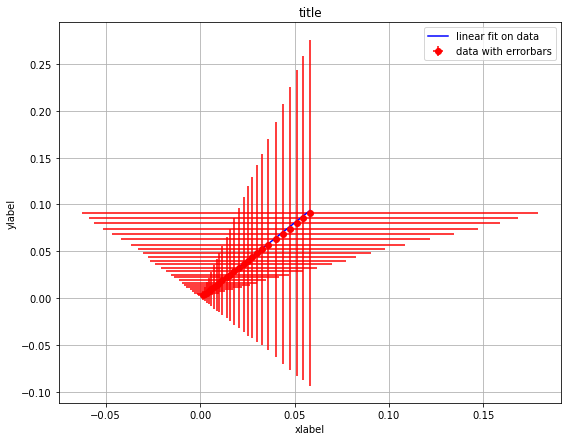

(array([1.60785627]), array([0.01538909]))

In [100]:
fit(runB2)